In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [3]:
# Load data

In [4]:
df = pd.read_parquet("../data/processed/credit.parquet")

In [5]:
df.drop('ID',axis=1,inplace=True)
df.reset_index(drop=True,inplace=True)

In [6]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
X = df.drop('default', axis=1)
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [8]:
# LightGBM

In [9]:
d_train = lgb.Dataset(X_train, label=y_train)
params = {'objective': 'binary', 'metric':'auc'}

In [10]:
model_lgb = lgb.train(params, d_train, num_boost_round=100)

[LightGBM] [Info] Number of positive: 5323, number of negative: 18677
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3264
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221792 -> initscore=-1.255256
[LightGBM] [Info] Start training from score -1.255256


In [11]:
pred_lgb = model_lgb.predict(X_test)
print("LGB AUC:", roc_auc_score(y_test, pred_lgb))

LGB AUC: 0.7814066097489598


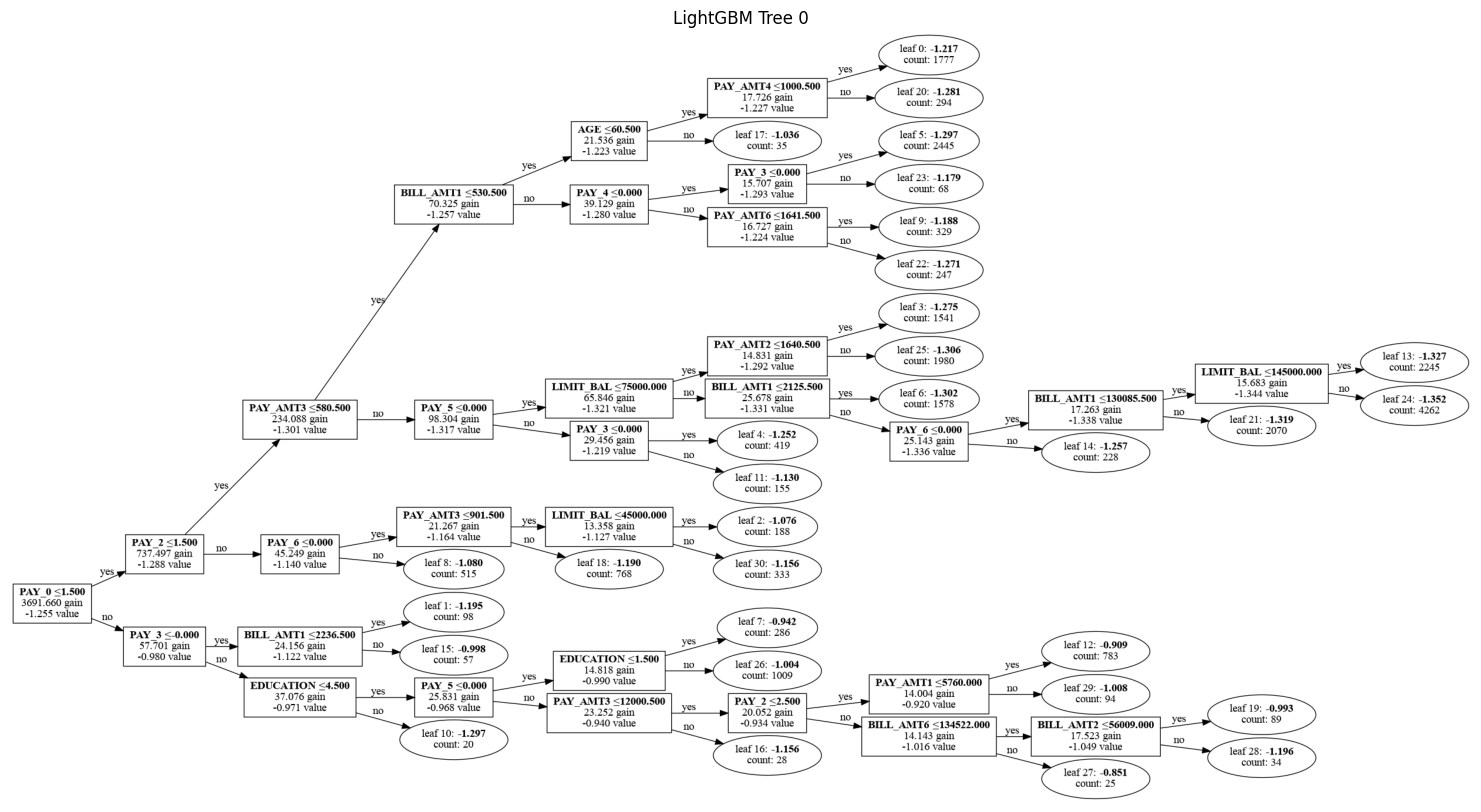

In [13]:
import lightgbm as lgb
import matplotlib.pyplot as plt

lgb.plot_tree(model_lgb, tree_index=0, figsize=(30, 10), show_info=['split_gain', 'internal_value', 'leaf_count'])
plt.title("LightGBM Tree 0")
plt.show()

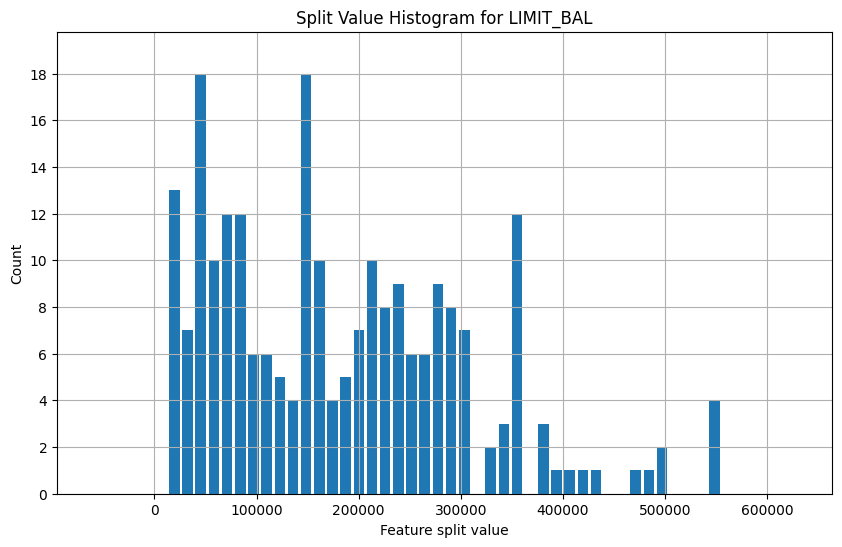

In [14]:
# Visualize how frequently each feature is used to split
lgb.plot_split_value_histogram(model_lgb, feature='LIMIT_BAL', figsize=(10, 6))
plt.title("Split Value Histogram for LIMIT_BAL")
plt.show()


In [39]:
# After training LightGBM model
model_lgb.save_model("../model/lgb_model.txt")

In [15]:
# XGBoost

In [16]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {'objective': 'binary:logistic', 'eval_metric':'auc'}

In [17]:
bst = xgb.train(params, dtrain, num_boost_round=100)
pred_xgb = bst.predict(dtest)
print("XGB AUC:", roc_auc_score(y_test, pred_xgb))

XGB AUC: 0.7749595346529778


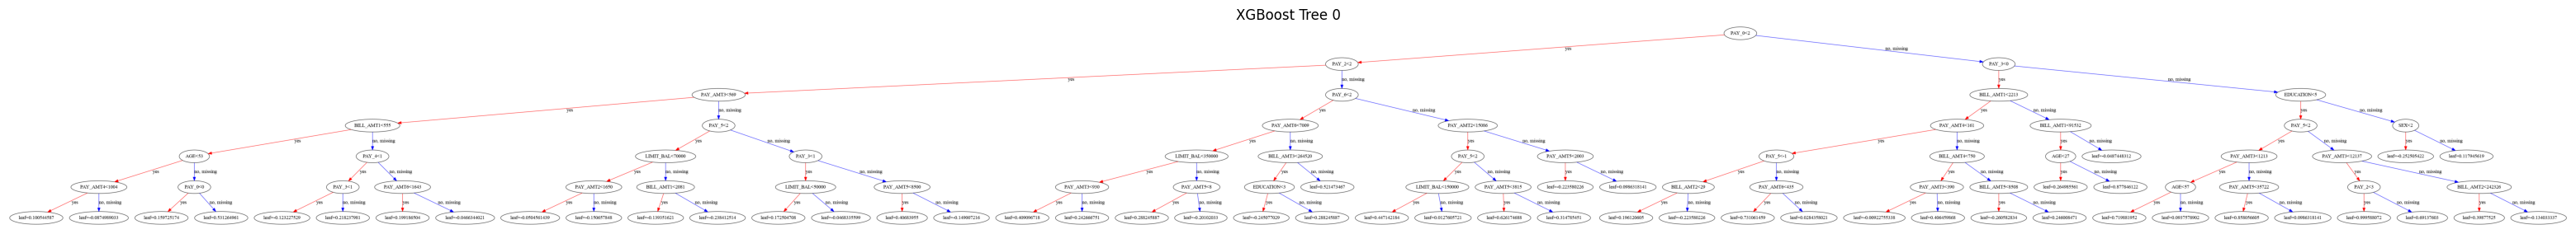

In [26]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot the first tree
xgb.plot_tree(bst, num_trees=0)
plt.rcParams['figure.figsize'] = [40, 20]
plt.title("XGBoost Tree 0")
plt.show()


In [ ]:
model = Booster(model_file='lgb_model.txt')

# **Hyperparameter tuning**

### Using RandomizedSearchCV for XGBoost

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import numpy as np

In [30]:
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='auc')

In [31]:
# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

In [32]:
random_search = RandomizedSearchCV(
    xgb_clf, param_distributions=param_dist, 
    n_iter=20, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1, random_state=42
)

In [33]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/alihassan/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:29:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/alihassan/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:29:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/alihassan/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:29:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/alihassan/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:29:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/alihassan/.local/lib/python3.12/site-packages/

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrai...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [35]:
best_model = random_search.best_estimator_
preds = best_model.predict_proba(X_test)[:, 1]
print("Tuned XGB AUC:", roc_auc_score(y_test, preds))
print("Best Parameters:", random_search.best_params_)

Tuned XGB AUC: 0.7844755738149515
Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 5, 'colsample_bytree': 0.8}
